In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import glob

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

from itertools import chain

sys.path.append('../../hamp_pred/')
from utils.tools import diffangle

sys.path.append('/home/nfs/sdunin/scr/lbs-tools/')
from lbs.dl.encoders import radius, phobos

import matplotlib.pyplot as plt

In [2]:
def scale_dict(d):
    a = np.asarray(list(d.values())).reshape(-1, 1)
    v = MinMaxScaler().fit_transform(a)
    v = v.reshape(len(d)).tolist()
    return dict(zip(d.keys(), v))

phobos_scaled = scale_dict(phobos)
radius_scaled = scale_dict(radius)

def encode(seq):
    return np.asarray(list(chain(*[(radius_scaled[i], phobos_scaled[i]) for i in list(seq)])))

In [3]:
def encode_df(data_df):
    n_enc = np.asarray([encode(i) for i in data_df.n_seq.tolist()])
    c_enc = np.asarray([encode(i) for i in data_df.c_seq.tolist()])
    return np.hstack([np.asarray(n_enc), np.asarray(c_enc)])

In [4]:
def get_labels(df):
    a = np.vstack(df['rot'].values)
    return (a[:,0::2] + a[:,1::2]) / 2

In [5]:
DATA_DIR = '../../data/input'

### Train and validation sets

In [6]:
data_set = os.path.join(DATA_DIR, 'af2_clean_model_1.p')
data_df = pd.read_pickle(data_set)
data_df['n_seq'] = data_df['n_seq'].apply(lambda x:x[1:-1])
data_df['c_seq'] = data_df['c_seq'].apply(lambda x:x[1:-1])
assert all(data_df['n_seq'].str.len() == 11)
assert all(data_df['c_seq'].str.len() == 11)
X = encode_df(data_df)
data_df['emb'] = list(X)
len(data_df)

4972

In [7]:
# train set
data_df_train = data_df[data_df['class']=='train']
X = np.asarray(data_df_train.emb.tolist())
y = get_labels(data_df_train)

# validation set
data_df_val = data_df[data_df['class']=='val']
X_val = np.asarray(data_df_val.emb.tolist())
y_val = get_labels(data_df_val)

### Train model using the train set

In [8]:
tuned_parameters = [
    {
        "hidden_layer_sizes": [  
                               (32, 32, 16, ),
                               (32, 64, 32, 16, ),
                               (32, 64, 64, 32, 16, ),
                               (32, 64, 128, 64, 32, 16,),
                               (32, 64, 128, 128, 64, 32, 16,),
                               (44, 64, 128, 128, 64, 32, 16, ),                               
                               (32, 64, 128, 128, 128, 64, 32, 16,),
                               ], 
        "solver": ['adam'],
        "n_iter_no_change": [20], 
        "max_iter": [10000], 
        "batch_size": ['auto']
    }
]

param_list = ParameterGrid(tuned_parameters)
res_dict = {}

In [ ]:
for n, p in enumerate(param_list):
    clf = MLPRegressor(**p, verbose=False)
    clf.fit(X, y)    
    y_pred = clf.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred)
        
    res_dict[n] = clf
    print(n+1, 'mae_val', np.round(mae_val, 1))
    

1 mae_val 7.8
2 mae_val 8.0
3 mae_val 8.3
4 mae_val 9.1
5 mae_val 9.1
6 mae_val 9.8


In [68]:
# save models
filename = os.path.join(DATA_DIR, 'regressor_models.p')
#pickle.dump(res_dict, open(filename, 'wb'))

### Performance on the PDB set

In [38]:
pdb_df = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
pdb_df.rename(columns={'seq1':'n_seq', 'seq2':'c_seq'}, inplace=True)
pdb_df = pdb_df[~pdb_df.mutant]
pdb_df['sequence'] = pdb_df['n_seq'] + pdb_df['c_seq'] 
len(pdb_df)

11

In [39]:
pdb_df['n_seq'] = pdb_df['n_seq'].apply(lambda x:x[1:-1])
pdb_df['c_seq'] = pdb_df['c_seq'].apply(lambda x:x[1:-1])
assert all(pdb_df['n_seq'].str.len() == 11)
assert all(pdb_df['c_seq'].str.len() == 11)

In [40]:
X_test = encode_df(pdb_df)
y_test = get_labels(pdb_df)

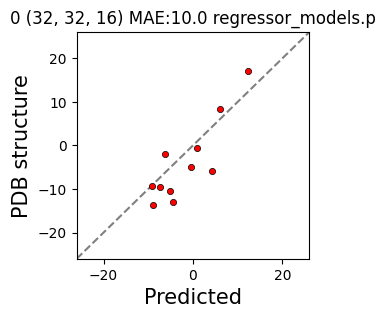

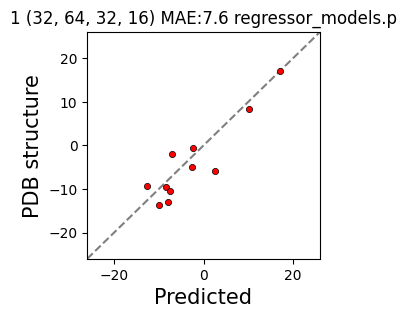

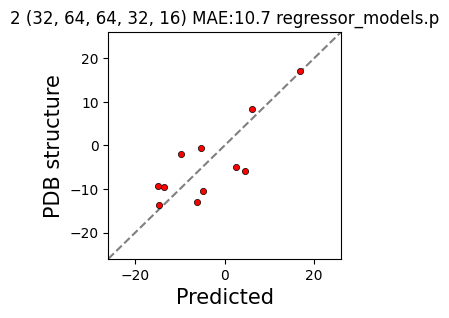

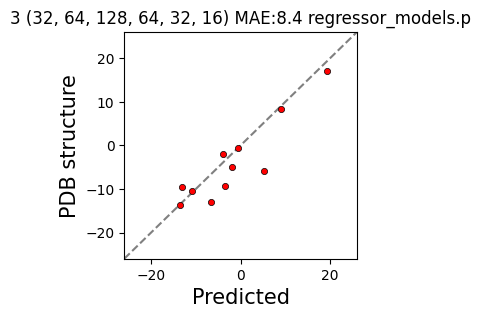

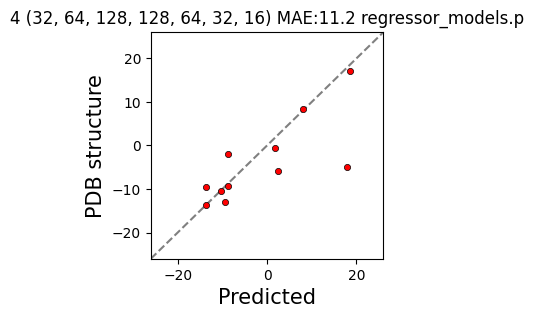

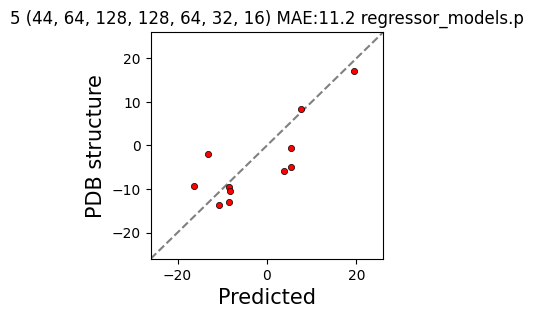

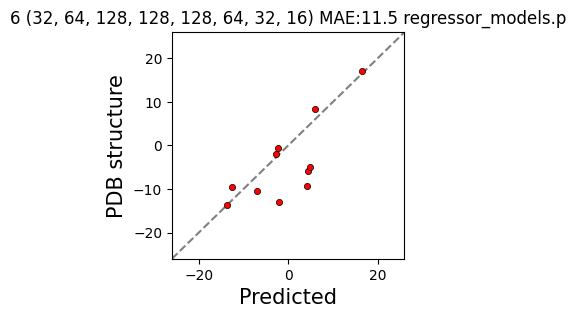

In [85]:
for filename in glob.glob(os.path.join(DATA_DIR, 'regressor_models.p')):
    res_dict = pickle.load(open(filename, 'rb'))

    for pos, clf in enumerate(res_dict.values()):    
        y_pred = clf.predict(X_test)
        y_pred_mean = y_pred.mean(axis=1) / 2
        y_test_mean = y_test.mean(axis=1) / 2

        mae = mean_absolute_error(y_test, y_pred)


        fig, ax = plt.subplots(1,1, figsize=(3, 3), dpi=100)
        ax.scatter(y_pred_mean, y_test_mean, color='red', s=20, lw=0.5, edgecolors='k')
        ax.set_ylim(-26, 26)
        ax.set_xlim(-26, 26)
        ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey', zorder=0)
        ax.set_xlabel('Predicted', size=15)
        ax.set_ylabel('PDB structure', size=15)
        ax.set_title(f'{pos} {clf.hidden_layer_sizes} MAE:{np.round(mae,1)} {os.path.basename(filename)}')
        pass

# Paper figure

In [82]:
#from hamp_pred.utils.encode import encode_df
filename = os.path.join(DATA_DIR, 'regressor_models.p')
res_dict = pickle.load(open(filename, 'rb'))
clf_aux = res_dict[1]

Text(0.5, 1.0, 'HAMPpred model #2')

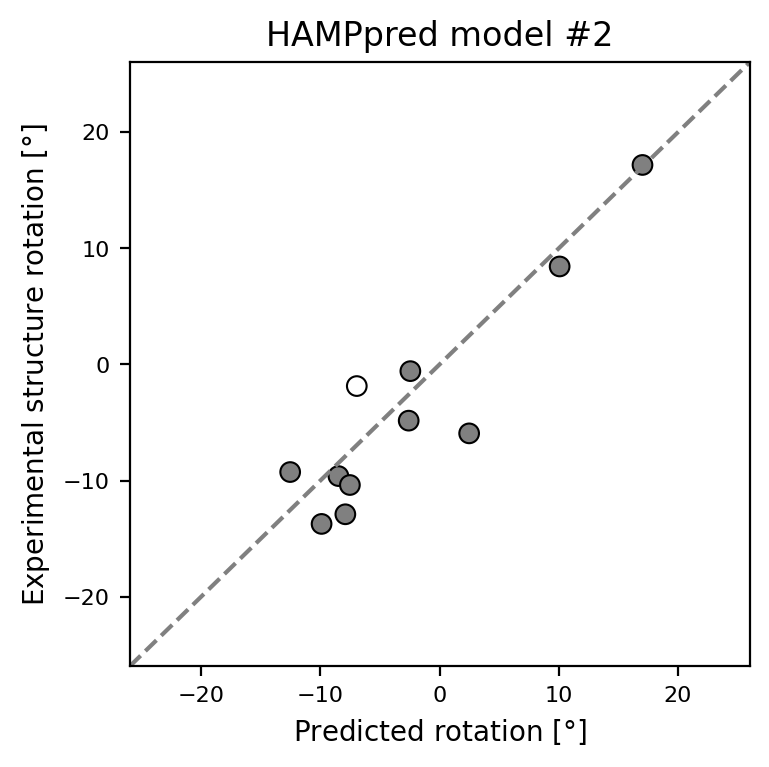

In [83]:
y_pred = clf_aux.predict(X_test)
y_pred_mean = y_pred.mean(axis=1) / 2
y_test_mean = y_test.mean(axis=1) / 2


title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in pdb_df.index]

ax.scatter(y_pred_mean, y_test_mean, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred model #2", size=title_font_size)
